# Neural Network Traning

In [164]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from CONSTANTS import ML
import os
import glob

print('---------------------------------------------------------------------------')
print('TF: {}'.format(tf.__version__))
print('---------------------------------------------------------------------------')

########################################################################
# Change file path HERE
########################################################################
dataDir = os.path.join(os.getcwd(), 'data')
csvFiles = glob.glob(dataDir + '/*.csv')

---------------------------------------------------------------------------
TF: 2.2.0
---------------------------------------------------------------------------


# Compiling dataset features

Total number of features = 19

### Power Spectrum Bins

1, 2, 3, 4, 10, 11, 22, 23, 43, 44, 45, 109, 110, 125, 126

### MFCC Bins

1, 10

### Spectral Flatness

Spectral flatness value and delta spectral flatness

In [165]:
def extractFeatures(df):
    datasets = np.empty([df.shape[0], ML['NUMBER_OF_FEATURES']])

    for index, row in df.iterrows():
        sample = np.array([
            row['powerSpectrum_1'],
            row['powerSpectrum_2'],
            row['powerSpectrum_3'],
            row['powerSpectrum_4'],
            row['powerSpectrum_10'],
            row['powerSpectrum_11'],
            row['powerSpectrum_22'],
            row['powerSpectrum_23'],
            row['powerSpectrum_43'],
            row['powerSpectrum_44'],
            row['powerSpectrum_45'],
            row['powerSpectrum_109'],
            row['powerSpectrum_110'],
            row['powerSpectrum_125'],
            row['powerSpectrum_126'],
            row['mfcc_1'],
            row['mfcc_10'],
            row['spectralFlatness'],
            row['delta_spectralFlatness']
        ])
        datasets[index] = sample
    
    return datasets

# Preprocessing

- Create one hot for the three classes (Chloe, Beep, and Music)
- Feature standardization
- Create Tensor datasets and shuffle the order

In [166]:
def standardize(x, axes=[0], epsilon=1e-8):
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed


def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int64)
    return x, y


def preprocess_standardized(x, y):
    x = tf.cast(x, tf.float32)
    x_normed = standardize(x)
    y = tf.cast(y, tf.int64)
    return x_normed, y


def create_dataset(xs, ys, n_classes=ML['N_CLASSES']):
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)).map(preprocess).shuffle(len(ys)).batch(128)


def create_dataset_standardized(xs, ys, n_classes=ML['N_CLASSES']):
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)).map(preprocess_standardized).shuffle(len(ys)).batch(128)

# Process datasets
- Get data from csv files
- Extract the 19 required features
- Create, shuffle, and split datasets into training and validation (80/20 ratio)


In [167]:
dataframes = []
for file in csvFiles:
    df = pd.read_csv(file, sep=',', header=0)
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

extracted_datasets = extractFeatures(df)
classes = df['class'].to_numpy()

x_train, x_validation, y_train, y_validation = train_test_split(extracted_datasets,
                                                                classes,
                                                                test_size=0.2,
                                                                shuffle=True) 

print('Train dataset:\t\t' + str(x_train.shape[0]))
print('Validation dataset:\t' + str(y_validation.shape[0]))
print('------------------------------')
print('Total dataset:\t\t' + str(extracted_datasets.shape[0]))
print('------------------------------')

Train dataset:		3959
Validation dataset:	990
------------------------------
Total dataset:		4949
------------------------------


# Training
- 2 hidden layers

In [168]:
train_dataset = create_dataset(x_train, y_train)
validation_dataset = create_dataset(x_validation, y_validation)

model = keras.Sequential([
    keras.layers.Dense(units=15, activation='relu'),
    keras.layers.Dense(units=8, activation='relu'),
    keras.layers.Dense(units=ML['N_CLASSES'], activation='softmax')
])

model.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_dataset.repeat(), 
    epochs=100, 
    steps_per_epoch=500,
    validation_data=validation_dataset.repeat(), 
    validation_steps=2
)

Epoch 1/100
500/500 [==============================] - 2s 3ms/step - loss: 0.7302 - accuracy: 0.8242 - val_loss: 0.7180 - val_accuracy: 0.8320
Epoch 2/100
500/500 [==============================] - 2s 4ms/step - loss: 0.6771 - accuracy: 0.8721 - val_loss: 0.6634 - val_accuracy: 0.8906
Epoch 3/100
500/500 [==============================] - 1s 3ms/step - loss: 0.6680 - accuracy: 0.8806 - val_loss: 0.6647 - val_accuracy: 0.8945
Epoch 4/100
500/500 [==============================] - 1s 3ms/step - loss: 0.6578 - accuracy: 0.8942 - val_loss: 0.6437 - val_accuracy: 0.9141
Epoch 5/100
500/500 [==============================] - 1s 3ms/step - loss: 0.6475 - accuracy: 0.9053 - val_loss: 0.6621 - val_accuracy: 0.8906
Epoch 6/100
500/500 [==============================] - 1s 3ms/step - loss: 0.6391 - accuracy: 0.9153 - val_loss: 0.6297 - val_accuracy: 0.9219
Epoch 7/100
500/500 [==============================] - 1s 3ms/step - loss: 0.6342 - accuracy: 0.9211 - val_loss: 0.6341 - val_accuracy: 0.9219

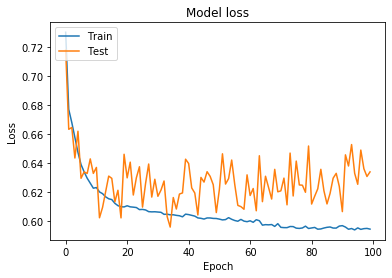

In [171]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()